## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi
from sklearn import preprocessing


## Datasets Preparation

In [2]:
def variable_preparation ():
    
    temp_i1 = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
               [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]

    temp_i2 = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
               [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

    saline_i1 = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
                 [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]

    saline_i2 = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
                 [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

    sil_i = (ds_bio.silicon.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
             [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    nitr_i = (ds_bio.nitrate.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    ammo_i = (ds_bio.ammonium.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    diat_i = (ds_bio.diatoms.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    flag_i = (ds_bio.flagellates.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]
    
    micro_i = (ds_bio.microzooplankton.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    meso_i = (ds_bio.mesozooplankton.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    return (temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i,  flag_i, micro_i, meso_i)


## SOM

In [3]:
def som (inputs, m, n):

    # Pre processing     
    indx = np.where(~np.isnan(inputs).any(axis=0))
    inputs2 = inputs[:,indx[0]]
    inputs3 = preprocessing.normalize(inputs2, norm= 'max')
    inputs3 = inputs3.transpose()

    # SOM
    temp_som = SOM(m, n, dim= inputs3[0,:].size, lr = 0.1)
    temp_som.fit(inputs3, epochs = 5)
    predictions = temp_som.predict(inputs3)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[0]] = predictions
    clusters = np.reshape(indx2,(898,398)) 

    # Preparation of the dataarray 
    clusters= xr.DataArray(clusters,
                    coords = {'y': temp_i1.y, 'x': temp_i1.x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    )
    
    return (clusters, unique)
    

## Plotting

In [4]:
def plotting (labels, titles, variables):

    fig, ax = plt.subplots(2,2, figsize=(10, 15))

    if variables[0].all() == clusters.all():

        cmap = plt.get_cmap('tab20', unique.max()+1)
        cmap.set_bad('gray')
        clus = variables[0].plot(ax=ax[0,0], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

        cbar = fig.colorbar(clus, ticks = unique+0.5) 
        cbar.set_ticklabels(unique)
        cbar.set_label(labels[0])

    else:
        
        cmap = plt.get_cmap('cubehelix')
        cmap.set_bad('gray')
        variables[0].plot(ax=ax[0,0], cmap=cmap, cbar_kwargs={'label': labels[0]})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.9, 
        top=0.95, 
        wspace=0.15, 
        hspace=0.15)
        
    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    variables[1].plot(ax=ax[0,1], cmap=cmap, cbar_kwargs={'label': labels[1]})
    variables[2].plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': labels[2]})

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text(titles[0])
    ax[0,1].title.set_text(titles[1])
    ax[1,0].title.set_text(titles[2])

    if len(titles) == 3:

        ax[1,1].axis('off')
    
    else:

        variables[3].plot(ax=ax[1,1], cmap=cmap, cbar_kwargs={'label': labels[3]})
        sa_vi.set_aspect(ax[1,1])
        ax[1,1].title.set_text(titles[3])

    fig.suptitle(str(date.date[0]))


## Main Body

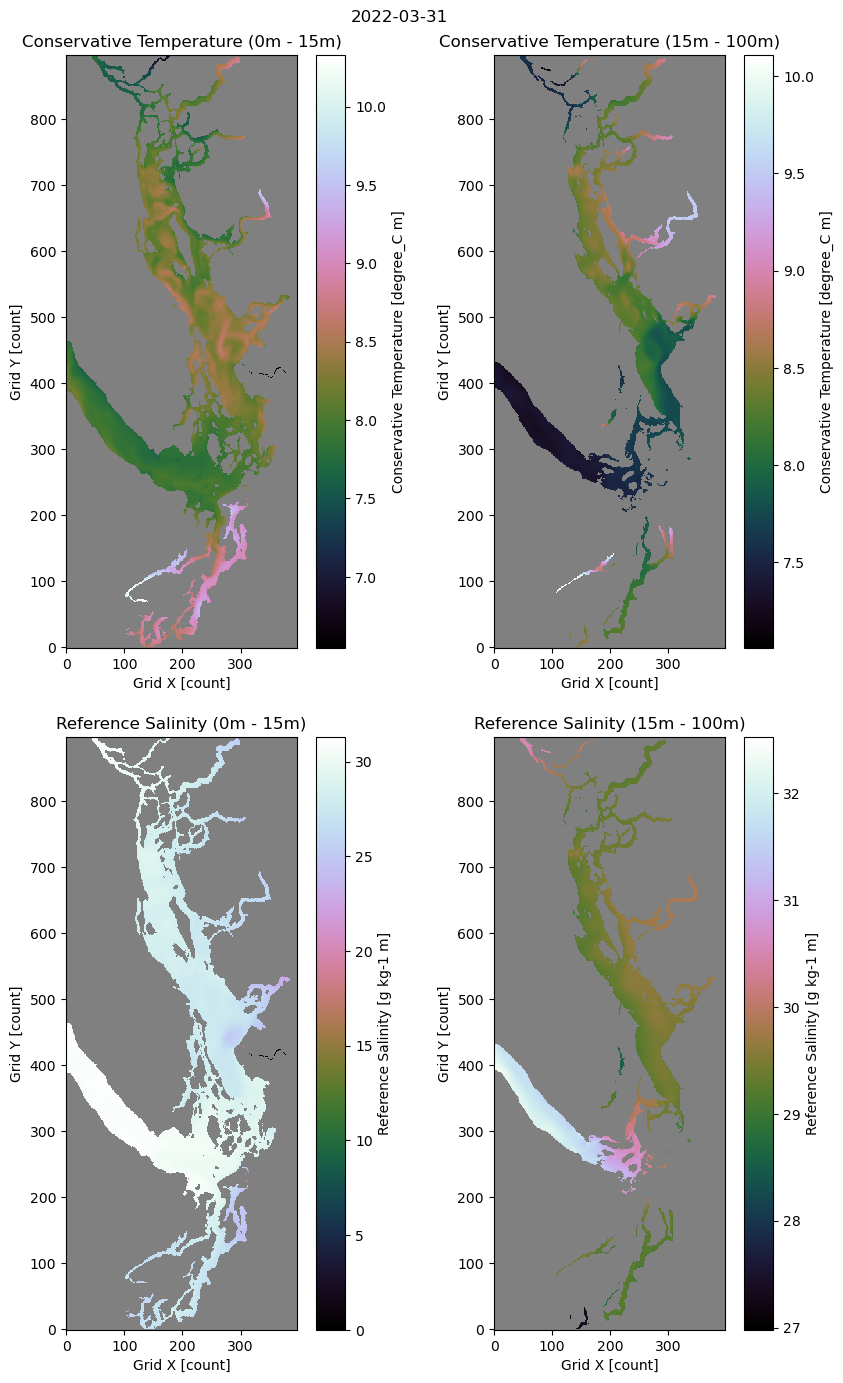

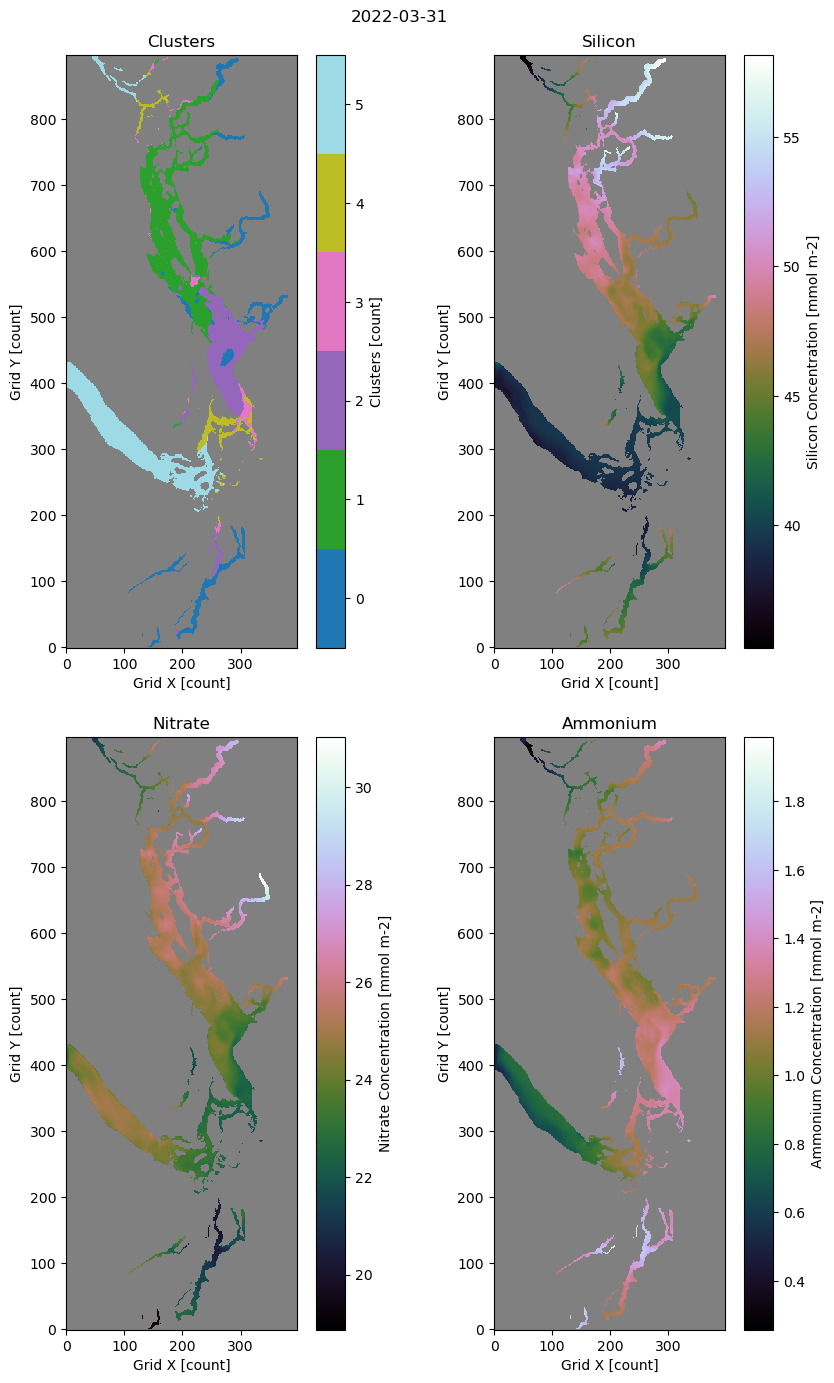

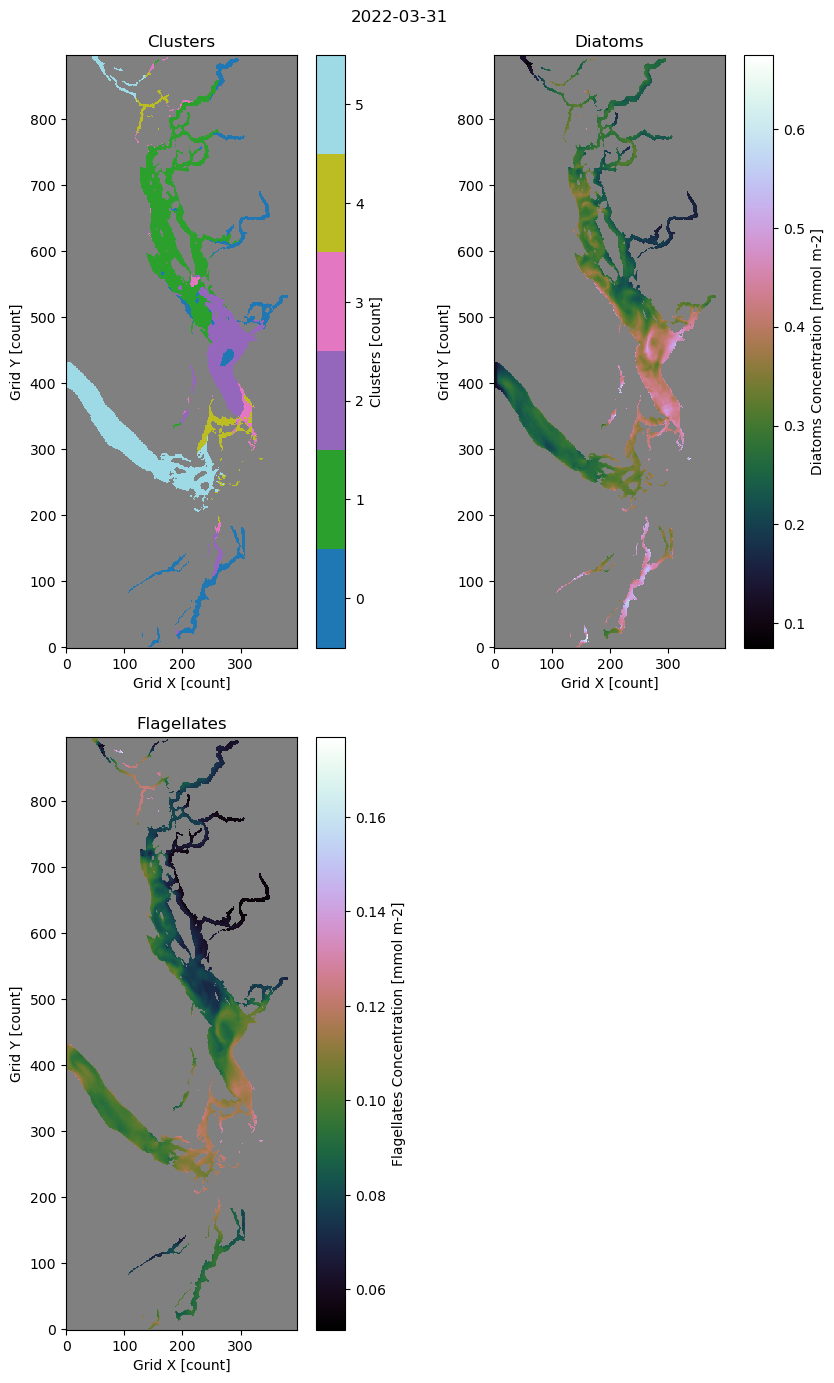

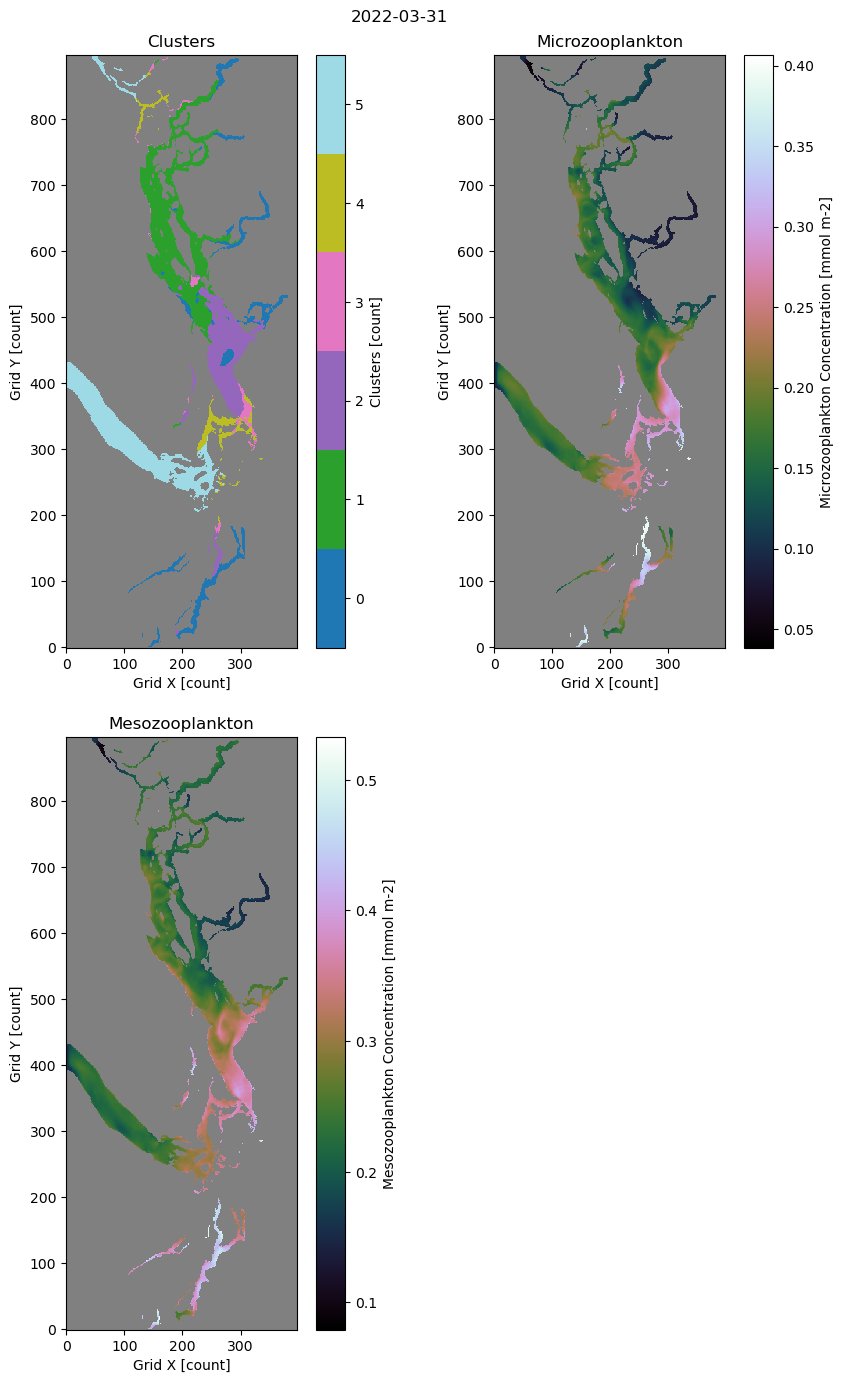

In [5]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i, flag_i, micro_i, meso_i = variable_preparation()

# Potential input variables
drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
nutrients = np.stack([np.ravel(sil_i), np.ravel(nitr_i), np.ravel(ammo_i)])
phyto = np.stack([np.ravel(diat_i), np.ravel(flag_i)])
zoo = np.stack([np.ravel(micro_i), np.ravel(meso_i)])

# Dimensions of the map
m = 3
n = 2

clusters, unique = som(drivers, m, n)

# Drivers
labels = ['Conservative Temperature [degree_C m]', 
            'Conservative Temperature [degree_C m]', 'Reference Salinity [g kg-1 m]',
            'Reference Salinity [g kg-1 m]']
titles = ['Conservative Temperature (0m - 15m)',
            'Conservative Temperature (15m - 100m)', 'Reference Salinity (0m - 15m)',
            'Reference Salinity (15m - 100m)']
variables = [temp_i1, temp_i2, saline_i1, saline_i2]
plotting (labels, titles, variables)

# Nutrients
labels = ['Clusters [count]', 'Silicon Concentration [mmol m-2]',
            'Nitrate Concentration [mmol m-2]', 'Ammonium Concentration [mmol m-2]']
titles = ['Clusters', 'Silicon', 'Nitrate', 'Ammonium']
variables = [clusters, sil_i, nitr_i, ammo_i]
plotting (labels, titles, variables)

# Phytoplankton
labels = ['Clusters [count]', 'Diatoms Concentration [mmol m-2]',
            'Flagellates Concentration [mmol m-2]']
titles = ['Clusters', 'Diatoms', 'Flagellates']
variables = [clusters, diat_i, flag_i]
plotting (labels, titles, variables)

# Zooplankton
labels = ['Clusters [count]', 'Microzooplankton Concentration [mmol m-2]',
            'Mesozooplankton Concentration [mmol m-2]']
titles = ['Clusters', 'Microzooplankton', 'Mesozooplankton']
variables = [clusters, micro_i, meso_i]
plotting (labels, titles, variables)
